In [2]:
import polars as pl
import numpy as np
import os, re, math
import matplotlib.pyplot as plt
import seaborn as sns
import typing
import dataclasses
import scipy.stats

In [97]:
%config InlineBackend.figure_formats = ['png']
plt.rcParams["figure.figsize"] = (10, 6)
def show():
    os.makedirs("plots", exist_ok=True)
    plt.savefig("plots/" + plt.gcf().axes[0].get_title() + ".pdf")
    plt.savefig("plots/" + plt.gcf().axes[0].get_title() + ".svg")
    plt.show()


In [6]:
df = pl.read_parquet("/home/exyi/Downloads/anglepairs/cWW-G-C-filtered.parquet")
dfAU = pl.read_parquet("/home/exyi/Downloads/anglepairs/cWW-A-U-filtered.parquet")

official_restraints = {
    "AT_DNA": [ 2.999, 2.825 ],
    "AU_RNA": [ 2.974, 2.829 ],
    "GC_DNA": [ 2.901, 2.907, 2.830 ],
    "GC_RNA": [ 2.916, 2.901, 2.819 ],
}

is_dna = pl.col("res1").str.starts_with("D") | pl.col("res2").str.starts_with("D")
is_rna = pl.col("res1").str.starts_with("D").is_not() | pl.col("res2").str.starts_with("D").is_not()

print(df.schema)
df.sum()

def running_stat(f):
    resolutions = np.arange(1.2, 3.5, 0.25)
    results = []
    for resolution in resolutions:
        results.append({
            "resolution": resolution,
            "value": f(df.filter((pl.col("resolution") < resolution) & (pl.col("resolution") >= resolution - 0.6)))
        })
    return pl.DataFrame(results)

legend = []
def get_spread(s: pl.DataFrame, relative_to: float):
    max_spread = s["value"].max() - s["value"].min()
    a2_spread = s.filter(pl.col("resolution") < 1.8).sort("resolution", descending=True)["value"][0] - s.sort("resolution", descending=True)["value"][0]

    return {
        "max_spread": max_spread / relative_to,
        "a18_spread": a2_spread / relative_to
    }

def plot_running_stat(f: typing.Callable[[pl.DataFrame], typing.Any], column: str, label: str):
    s = running_stat(f)
    plt.plot(s["value"].to_numpy(), s["resolution"].to_numpy())
    spread = get_spread(s, relative_to=1)
    legend.append(f"{label} {spread['max_spread']:.4f} {spread['a18_spread']:.4f}")
    print(f"{label}: {s}")
def sample_for_kde(x: np.ndarray, threshold = 5_000):
    if len(x) <= threshold:
        return x
    else:
        return np.random.choice(x, threshold, replace=False)

def mode(arr, bw_factor = 1.0) -> float:
    if len(arr) < 5:
        return np.mean(arr)

    kde = scipy.stats.gaussian_kde(sample_for_kde(arr))
    kde.set_bandwidth(lambda _: kde.scotts_factor() * bw_factor)
    mode = np.argmax(kde.pdf(arr))
    return arr[mode]

OrderedDict([('pdbid', String), ('model', Int64), ('chain1', String), ('chain2', String), ('res1', String), ('res2', String), ('nr1', Int64), ('nr2', Int64), ('alt1', String), ('alt2', String), ('ins1', String), ('ins2', String), ('symmetry_operation', String), ('type', String), ('hb_0_length', Float32), ('hb_0_donor_angle', Float32), ('hb_0_acceptor_angle', Float32), ('hb_0_donor_OOPA', Float32), ('hb_0_acceptor_OOPA', Float32), ('hb_1_length', Float32), ('hb_1_donor_angle', Float32), ('hb_1_acceptor_angle', Float32), ('hb_1_donor_OOPA', Float32), ('hb_1_acceptor_OOPA', Float32), ('hb_2_length', Float32), ('hb_2_donor_angle', Float32), ('hb_2_acceptor_angle', Float32), ('hb_2_donor_OOPA', Float32), ('hb_2_acceptor_OOPA', Float32), ('hb_3_length', Float32), ('hb_3_donor_angle', Float32), ('hb_3_acceptor_angle', Float32), ('hb_3_donor_OOPA', Float32), ('hb_3_acceptor_OOPA', Float32), ('coplanarity_angle', Float32), ('coplanarity_shift1', Float32), ('coplanarity_shift2', Float32), ('copl

/tmp/ipykernel_671484/229542189.py:12: DeprecationWarning: `is_not` is deprecated. It has been renamed to `not_`.
  is_rna = pl.col("res1").str.starts_with("D").is_not() | pl.col("res2").str.starts_with("D").is_not()


In [126]:

column = "hb_2_length"
stats: dict[str, typing.Callable[[pl.Series], float]] = {
    "mean": lambda col:float(col.mean()),
    "mean_p90": lambda col: float(col.filter((col < col.quantile(0.95)) & (col > col.quantile(0.05))).mean()),
    "mean_p80": lambda col: float(col.filter((col < col.quantile(0.90)) & (col > col.quantile(0.10))).mean()),
}
def create_stat_quantile(p: float):
    return lambda col: float(col.quantile(p))
def create_stat_mode(bw_factor: float):
    return lambda col:float(mode(col.drop_nulls().to_numpy(), bw_factor=bw_factor))
for p in np.arange(30, 70, 1):
    stats[f"P{p}"] = create_stat_quantile(p / 100)
# for p in np.arange(0.5, 3.0, 0.1):
#     stats[f"mode_{p:1.1f}"] = create_stat_mode(p)

stat_names = list(stats.keys())

# sns.kdeplot(df, levels=40, thresh=0.02, x=column, y="resolution").set(title=f"{column} x resolution density", ylabel="resolution (Å)")
# plot_running_stat(lambda df: float(df[column].median()), column, "median")
# plot_running_stat(lambda df: float(df[column].mean()), column, "mean")
# plot_running_stat(lambda df: float(df[column].quantile(0.25)), column, "P25")
# plot_running_stat(lambda df: float(mode(df[column].drop_nulls().to_numpy())), column, "mode")
# plt.legend(legend)
# plt.xlim(2.5, 3.5)
# show()
# sns.histplot(df.filter(is_some_quality), x="hb_1_donor_angle", y="resolution").set(title="cWW CG pair H-Bond donor angle", xlabel="C6-N1 · · · N3 H-bond angle (°)", ylabel="resolution (Å)")
# show()
# sns.histplot(df.filter(is_some_quality), x="hb_1_acceptor_angle", y="resolution").set(title="cWW CG pair H-Bond acceptor angle", xlabel="C6-N1 · · · N3 H-bond angle (°)", ylabel="resolution (Å)")
# show()
# sns.histplot(df.filter(is_some_quality), x="hb_1_length", y="resolution").set(title="cWW CG pair H-Bond length", xlabel="N1 · · · N3 H-bond length (Å)", ylabel="resolution (Å)")
# show()


Best quantile: shape: (1, 4)
┌──────────┬─────────────┬─────────────┬─────────────┐
│ quantile ┆ hb_0_length ┆ hb_1_length ┆ hb_2_length │
│ ---      ┆ ---         ┆ ---         ┆ ---         │
│ f64      ┆ f64         ┆ f64         ┆ f64         │
╞══════════╪═════════════╪═════════════╪═════════════╡
│ 0.45     ┆ -0.127479   ┆ -0.053816   ┆ 0.144968    │
└──────────┴─────────────┴─────────────┴─────────────┘
Mode: {'hb_0_length': -0.027917195449046372, 'hb_1_length': -0.005846566777208878, 'hb_2_length': 0.25989286799213873}


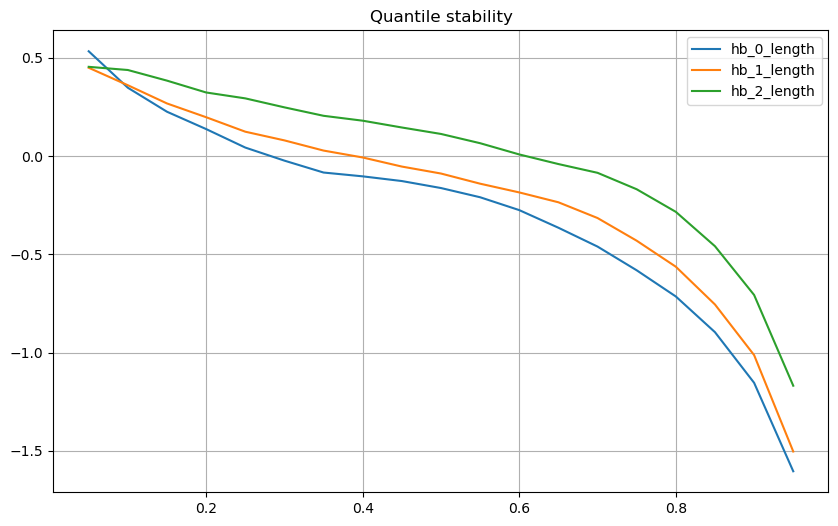

In [5]:
# columns = [ "hb_0_length", "hb_1_length", "hb_2_length", "hb_0_donor_angle", "hb_1_donor_angle", "hb_2_donor_angle", "hb_0_acceptor_angle", "hb_1_acceptor_angle", "hb_2_acceptor_angle" ]
columns = [ "hb_0_length", "hb_1_length", "hb_2_length" ]
data = []
plt.title("Quantile stability")
for quantile in np.arange(0.05, 1, 0.05):
    row = { "quantile": quantile }
    for column in columns:
        row[column] = get_spread(running_stat(lambda df: float(df[column].quantile(quantile))), relative_to=df[column].std())["a18_spread"]
    data.append(row)
data = pl.DataFrame(data)
for column in columns:
    plt.plot(data["quantile"].to_numpy(), data[column].to_numpy())
plt.grid()
plt.legend(columns)
best_quantile = data.sort(pl.sum_horizontal(pl.col(col) ** 2 for col in columns))[0]
print(f"Best quantile: {best_quantile}")
m = {
    col: get_spread(running_stat(lambda df: float(mode(df[col].drop_nulls().to_numpy()))), relative_to=df[col].std())["a18_spread"]
    for col in columns
}
print(f"Mode: {m}")
show()

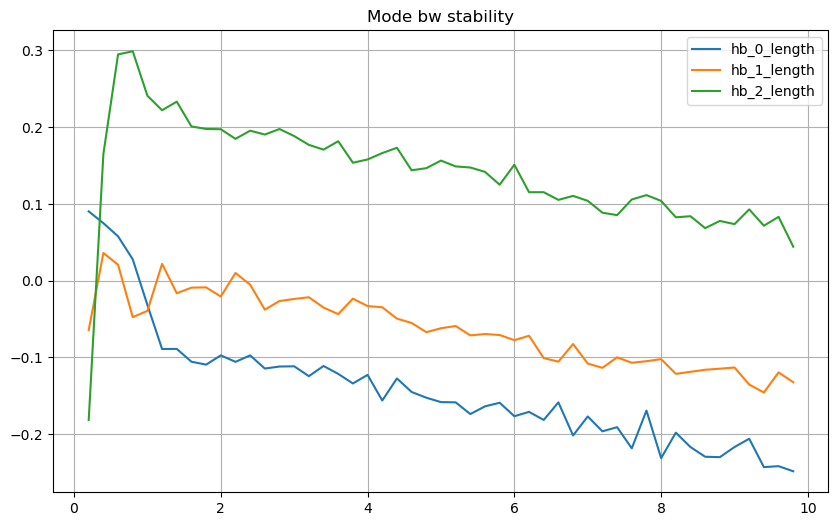

Best bw: 0.4


In [6]:
plt.title("Mode bw stability")
data = []
for bw_factor in np.arange(0.2, 10, 0.2):
    row = { "bw_factor": bw_factor }
    for column in columns:
        row[column] = get_spread(running_stat(lambda df: float(mode(df[column].drop_nulls().to_numpy(), bw_factor))), relative_to=df[column].std())["a18_spread"]
    data.append(row)
data = pl.DataFrame(data)
for column in columns:
    plt.plot(data["bw_factor"].to_numpy(), data[column].to_numpy())
plt.grid()
plt.legend(columns)
show()
best_bw = data.sort(pl.sum_horizontal(pl.col(col) ** 2 for col in columns))["bw_factor"][0]
print(f"Best bw: {best_bw}")

In [127]:
    
# parameters = [ "hb_0_length", "hb_1_length", "hb_2_length", "hb_0_donor_angle", "hb_1_donor_angle", "hb_2_donor_angle", "hb_0_acceptor_angle", "hb_1_acceptor_angle", "hb_2_acceptor_angle" ]
params_lengths = [ "hb_0_length", "hb_1_length", "hb_2_length" ]
params_angles_hb = [ "hb_0_donor_angle", "hb_0_acceptor_angle", "hb_1_donor_angle", "hb_1_acceptor_angle", "hb_2_donor_angle", "hb_2_acceptor_angle" ]
params_angle_hb_plane = ["hb_1_donor_OOPA", "hb_1_acceptor_OOPA", "hb_0_donor_OOPA", "hb_0_acceptor_OOPA", "hb_2_donor_OOPA", "hb_2_acceptor_OOPA" ]
params_angles_plane = [ "C1_C1_yaw1", "C1_C1_pitch1", "C1_C1_roll1", "coplanarity_angle", "coplanarity_edge_angle1" ]
params_plane_shift = [ "coplanarity_shift1", "coplanarity_shift2" ]

def bootstrap(df: pl.DataFrame, n: int, params):
    sample = df.sample(n=n)

    stat_matrix = np.zeros((len(params), len(stats)))
    for i, parameter in enumerate(params):
        for j, (stat_name, stat) in enumerate(stats.items()):
            stat_matrix[i, j] = stat(sample[parameter])
    return stat_matrix

def bootstraps(df: pl.DataFrame, n: int, m: int, params):
    return [ bootstrap(df, n, params) for i in range(0, m) ]

bootstrap_filter = pl.lit(True)
# bootstrap_filter = pl.col("resolution") > 2.5
straps_rna = bootstraps(df.filter(is_rna & bootstrap_filter), 100, 2000, params_lengths)
straps_dna = bootstraps(df.filter(is_dna & bootstrap_filter), 100, 2000, params_lengths)

straps_rna_au = bootstraps(dfAU.filter(is_rna & bootstrap_filter), 100, 2000, params_lengths[:2])
straps_dna_au = bootstraps(dfAU.filter(is_dna & bootstrap_filter), 100, 2000, params_lengths[:2])

(43, 3)
P46 19 0.02298489674480756
[(array([0.03385072, 0.04894088, 0.1090072 ]), 'P31', 31.0), (array([0.0299839 , 0.04591757, 0.10502753]), 'P32', 32.0), (array([0.0265436 , 0.04293168, 0.10104697]), 'P33', 33.0), (array([0.02335477, 0.04017565, 0.0973399 ]), 'P34', 34.0), (array([0.02037995, 0.03736068, 0.09350825]), 'P35', 35.0), (array([0.01799012, 0.03471422, 0.08972522]), 'P36', 36.0), (array([0.01603427, 0.03206603, 0.08607582]), 'P37', 37.0), (array([0.01460595, 0.02954028, 0.08239795]), 'P38', 38.0), (array([0.0137413 , 0.02713258, 0.07868005]), 'P39', 39.0), (array([0.0134228 , 0.02472545, 0.07506257]), 'P40', 40.0), (array([0.01375967, 0.02249735, 0.071475  ]), 'P41', 41.0), (array([0.01463802, 0.02035017, 0.06783907]), 'P42', 42.0), (array([0.0159507 , 0.01833718, 0.06416873]), 'P43', 43.0), (array([0.0178411 , 0.01652918, 0.06047968]), 'P44', 44.0), (array([0.02014258, 0.01491883, 0.05702522]), 'P45', 45.0), (array([0.02282493, 0.01353038, 0.0533386 ]), 'P46', 46.0), (arr

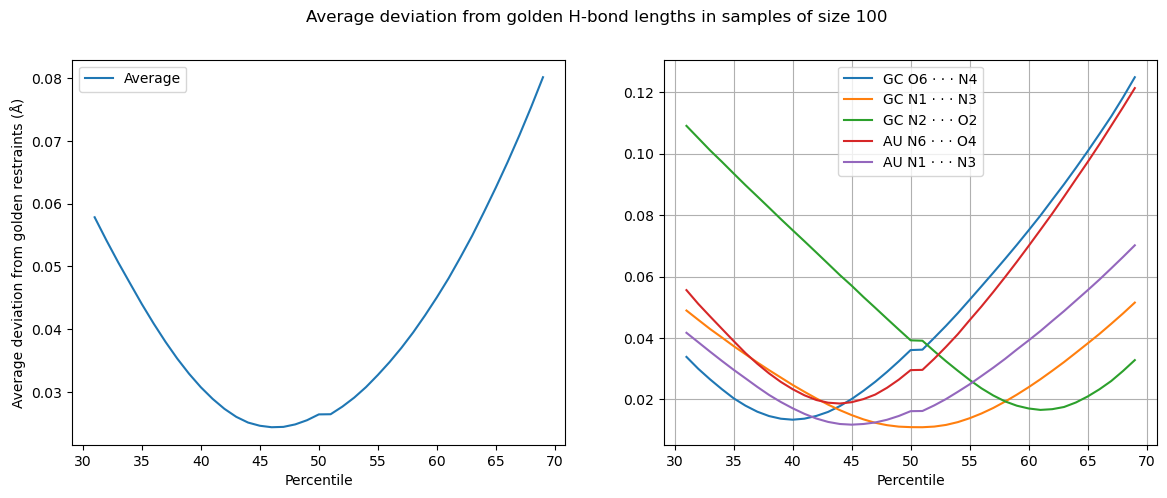

In [129]:
def calc_gold_deviation(bootstraps, gold):
    return np.mean([ np.abs(boot.T - gold) for boot in bootstraps ], axis=0)

# def calc_self_deviation(bootstraps, parameters):
#     means = np.mean(bootstraps, axis=0)
#     return np.mean([ np.abs(boot - means) for boot in bootstraps ], axis=0)

stat_deviation = np.mean([
    calc_gold_deviation(straps_rna, official_restraints["GC_RNA"]),
    calc_gold_deviation(straps_dna, official_restraints["GC_DNA"])
], axis=0)
print(stat_deviation.shape)
# print(stat_deviation)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

modes = [ (stat_deviation[i], stat_names[i], float(parsed.group(1))) for i in range(len(stat_names)) if (parsed := re.match(r"^P(\d+(\.\d+)?)$", stat_names[i])) if 30 < float(parsed.group(1)) < 70 ]

ax[1].plot([ mode[2] for mode in modes ], [ mode[0] for mode in modes ])

stat_deviation_au = np.mean([
    calc_gold_deviation(straps_rna_au, official_restraints["AU_RNA"]),
    calc_gold_deviation(straps_dna_au, official_restraints["AT_DNA"])
], axis=0)
modes_au = [ (stat_deviation_au[i], stat_names[i], float(parsed.group(1))) for i in range(len(stat_names)) if (parsed := re.match(r"^P(\d+(\.\d+)?)$", stat_names[i])) if 30 < float(parsed.group(1)) < 70 ]
stat_deviation_mean = np.mean([ np.mean(stat_deviation, axis=1), np.mean(stat_deviation_au, axis=1) ], axis=0)
# print(stat_deviation_mean)
# assert False
print(stat_names[np.argmin(stat_deviation_mean)], np.argmin(stat_deviation_mean), np.min(stat_deviation_mean))

print(modes)
plt.xlabel("KDE Bandwidth factor")
ax[1].plot([ mode[2] for mode in modes_au ], [ mode[0] for mode in modes_au ])
ax[1].legend([ "GC O6 · · · N4", "GC N1 · · · N3", "GC N2 · · · O2", "AU N6 · · · O4", "AU N1 · · · N3" ])
ax[0].plot([ mode[2] for mode in modes ], [ np.mean([*modes[i][0], *modes_au[i][0]]) for i in range(len(modes)) ])
ax[0].legend([ "Average" ])
plt.suptitle("Average deviation from golden H-bond lengths in samples of size 100")
ax[1].set(xlabel ="Percentile")
ax[0].set(xlabel ="Percentile", ylabel="Average deviation from golden restraints (Å)")
plt.grid()
fig.savefig("plots/average_deviation.svg")
show()